In [83]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

import matplotlib.pyplot as plt


In [84]:
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)


In [85]:
"""# Training Loop on CIFAR 10.
 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.
"""

# Reading in the dataset
transform = transforms.Compose(
    [
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# The training loop
def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)

    loss_values = []
    accuracy_vals = []

    overall_step = 0
    
    for epoch in range(epochs):
        correct = 0
        total = 0
        epoch_loss = 0

        if(epoch == 40):
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01
        elif (epoch == 80):
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.001
                
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 1000 == 1:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                  epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
                info = { ('loss_' + model_name): loss.item() }
        overall_step += 1

        epoch_loss /= len(train_loader)
        print("Epoch loss: " + str(epoch_loss))
        loss_values.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100*(correct / total)        
            accuracy_vals.append(accuracy)

    print('Accuracy of the network on the test images: {} %'.format(accuracy))
    return loss_values, accuracy_vals

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
model = allcnn_t().to(device)

#TODO: Set it as number of epochs states in the question (100)
epochs = 50

#Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()

#Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# Training loop called here
loss_values, accuracy_values = train(
    model, optimizer, criterion, trainloader, testloader, epochs, 'cnn', True)

Num parameters:  1667166
Epoch [1/50], Step [1/391], Loss: 2.3048
Epoch loss: 1.8943310451629523
Epoch [2/50], Step [1/391], Loss: 1.7341
Epoch loss: 1.6562809782564794
Epoch [3/50], Step [1/391], Loss: 1.6091
Epoch loss: 1.5242950462014473
Epoch [4/50], Step [1/391], Loss: 1.5121
Epoch loss: 1.4231103692213287
Epoch [5/50], Step [1/391], Loss: 1.3133
Epoch loss: 1.338760468965906
Epoch [6/50], Step [1/391], Loss: 1.3449
Epoch loss: 1.263521162445283
Epoch [7/50], Step [1/391], Loss: 1.1703
Epoch loss: 1.205997761862967
Epoch [8/50], Step [1/391], Loss: 1.2420
Epoch loss: 1.1556124601827558
Epoch [9/50], Step [1/391], Loss: 1.1938
Epoch loss: 1.1126051234162373
Epoch [10/50], Step [1/391], Loss: 1.2976


KeyboardInterrupt: ignored

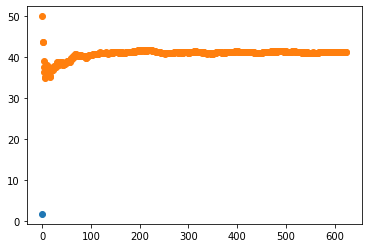

In [20]:
loss_values

# Plot the training and validation losses as a function of the number of epochs
plt.scatter(range(len(loss_values)), loss_values)

# Plot the training and validation errors as a function of the number of epochs
plt.scatter(range(len(accuracy_values)), accuracy_values)

Since all classes start with equal probability,
$-ln(0.1)$ = 2.3

In [69]:
eta = 1e-5

In [70]:
training_batch_loss = []
stop_val = 150

In [71]:
learning_rate = []
learning_rate.append(eta)
for i in range(stop_val):
    learning_rate.append(learning_rate[-1] * 1.1)

In [72]:
# The training loop
def train_lr(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)

    loss_values = []
    accuracy_vals = []

    overall_step = 0
    
    for epoch in range(epochs):
        correct = 0
        total = 0
        epoch_loss = 0
                
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

            training_batch_loss.append(loss.item())
            if(len(training_batch_loss) > stop_val):
                break

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for g in optimizer.param_groups:
                g['lr'] *= 1.1

            if (i+1) % 1000 == 1:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                  epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
                info = { ('loss_' + model_name): loss.item() }
        overall_step += 1

        epoch_loss /= len(train_loader)
        print("Epoch loss: " + str(epoch_loss))
        loss_values.append(epoch_loss)
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100*(correct / total)        
            accuracy_vals.append(accuracy)

    print('Accuracy of the network on the test images: {} %'.format(accuracy))
    return loss_values, accuracy_vals

In [73]:
model = allcnn_t().to(device)

#TODO: Set it as number of epochs states in the question (100)
epochs = 1

#Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()

#Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=eta, momentum=0.9, weight_decay=0.001)

# Training loop called here
loss_values, accuracy_values = train_lr(
    model, optimizer, criterion, trainloader, testloader, epochs, 'cnn', True)

Num parameters:  1667166
Epoch [1/1], Step [1/391], Loss: 2.3153
Epoch loss: 0.8207876328617105
Accuracy of the network on the test images: 10.11 %


In [74]:
len(training_batch_loss)

151

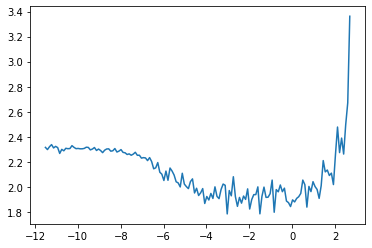

In [75]:
plt.plot(np.log(learning_rate[:150]), training_batch_loss[:150])
plt.show()

In [76]:
min_ix = np.argmin(training_batch_loss)
print(learning_rate[min_ix])
print(training_batch_loss[min_ix])

0.04830020556225739
1.7841922044754028


In [162]:
T0 = 19550 / 5
T = 19550
eta_max = 1e-2 # eye-balling the minimum / 10

In [163]:
training_loss = []
validation_loss = []

training_error = []
validation_error = []

In [164]:
# The training loop
def train_lr(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)

    overall_step = 0
    t = 0

    for epoch in range(epochs):
        correct = 0
        total = 0
        epoch_loss = 0

        model.train()
                
        for i, (images, labels) in enumerate(train_loader):

            # update learning rate
            if t < T0:
                new_lr = 1e-4 + (t/T0)*nmax
            else:
                new_lr = nmax*np.cos((np.pi/2)*(t - T0)/(T - T0)) + 1e-6
            
            for g in optimizer.param_groups:
                g['lr'] = new_lr

            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward Pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t += 1
    
            training_loss.append(loss.item())
            training_error.append(1 - correct/total)

            if (i) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))

        epoch_loss /= len(train_loader)
        print("Epoch loss: " + str(epoch_loss))
        loss_values.append(epoch_loss)
    
        model.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            validation_loss.append(loss.item())
            validation_error.append(1 - correct / total)

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    return 

In [165]:
model = allcnn_t().to(device)

epochs = 50

#Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()

#Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=eta, momentum=0.9, weight_decay=0.001)

# Training loop called here
train_lr(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn', True)

Num parameters:  1667166
Epoch [1/50], Step [1/391], Loss: 2.2975
Epoch [1/50], Step [101/391], Loss: 2.1078
Epoch [1/50], Step [201/391], Loss: 1.9483
Epoch [1/50], Step [301/391], Loss: 1.9817
Epoch loss: 0.0
Epoch [2/50], Step [1/391], Loss: 1.7292
Epoch [2/50], Step [101/391], Loss: 1.8746
Epoch [2/50], Step [201/391], Loss: 1.7938
Epoch [2/50], Step [301/391], Loss: 1.7377
Epoch loss: 0.0
Epoch [3/50], Step [1/391], Loss: 1.6278
Epoch [3/50], Step [101/391], Loss: 1.5064
Epoch [3/50], Step [201/391], Loss: 1.4964
Epoch [3/50], Step [301/391], Loss: 1.5147
Epoch loss: 0.0
Epoch [4/50], Step [1/391], Loss: 1.4488
Epoch [4/50], Step [101/391], Loss: 1.4401
Epoch [4/50], Step [201/391], Loss: 1.3071
Epoch [4/50], Step [301/391], Loss: 1.3397
Epoch loss: 0.0
Epoch [5/50], Step [1/391], Loss: 1.2333
Epoch [5/50], Step [101/391], Loss: 1.1833
Epoch [5/50], Step [201/391], Loss: 1.2305
Epoch [5/50], Step [301/391], Loss: 1.0268
Epoch loss: 0.0
Epoch [6/50], Step [1/391], Loss: 1.1651
Epoc

In [166]:
t_array_val = [391 * x for x in range(0, epochs)]
t_array_test = np.arange(0, 391*epochs)

In [167]:
print(len(training_loss))
print(len(validation_loss))

19550
50


In [168]:
print(len(training_error))
print(len(validation_error))

19550
50


In [175]:
plt.rcParams["figure.figsize"] = (10,10)

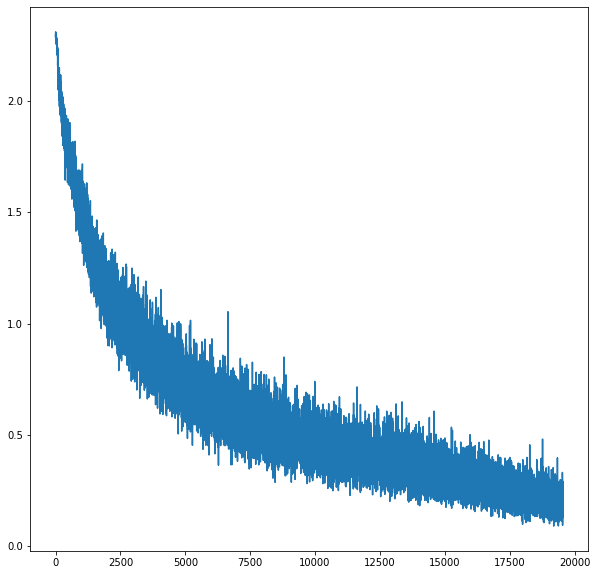

In [176]:
plt.plot(t_array_test,training_loss)

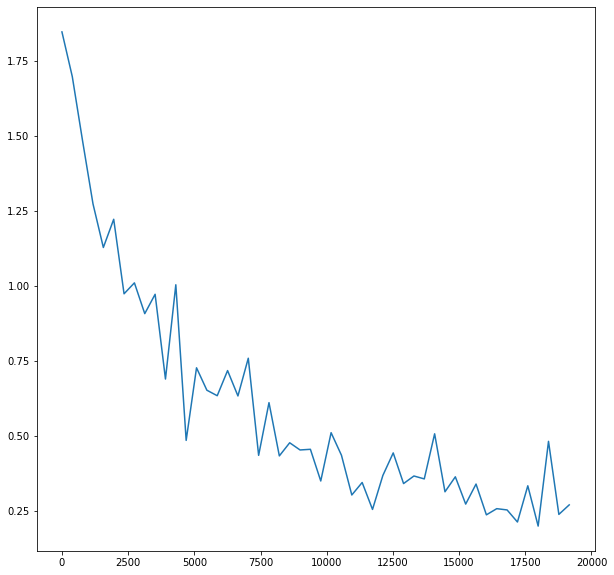

In [177]:
plt.plot(t_array_val, validation_loss)

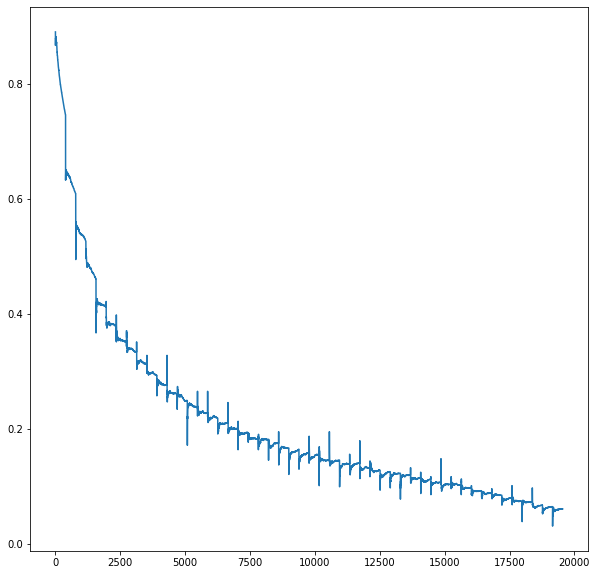

In [178]:
plt.plot(t_array_test, training_error)

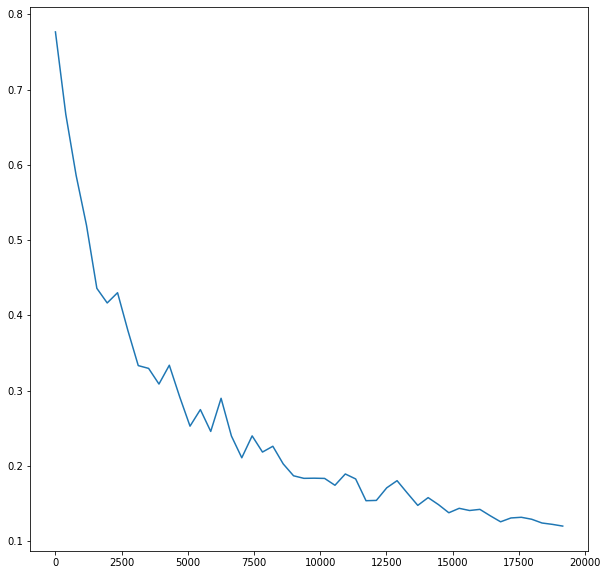

In [179]:
plt.plot(t_array_val, validation_error)

In [180]:
# The training loop
def train_scenario(net, optimizer, criterion, train_loader, test_loader, epochs, max_eta):
    model = net.to(device)
    total_step = len(train_loader)

    overall_step = 0
    t = 0

    for epoch in range(epochs):
        correct = 0
        total = 0
        epoch_loss = 0

        model.train()
                
        for i, (images, labels) in enumerate(train_loader):

            # update learning rate
            if t < T0:
                new_lr = 1e-4 + (t/T0)*max_eta
            else:
                new_lr = max_eta*np.cos((np.pi/2)*(t - T0)/(T - T0)) + 1e-6
            
            for g in optimizer.param_groups:
                g['lr'] = new_lr

            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward Pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t += 1
    
        epoch_loss /= len(train_loader)
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        validation_loss.append(loss.item())
        validation_error.append(1 - correct / total)

    print('Validation Error: {} %'.format(100 * (1 - correct / total)))
    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    return 

In [181]:
eta_max_arr = [eta_max, 5 * eta_max, eta_max]
rho = [0.9, 0.5, 0.5]
validation_error = []
validation_loss = []

In [182]:

epochs = 50

for i in range(0, 3):
    model = allcnn_t().to(device)

    #Define the loss function as asked in the question
    criterion = nn.CrossEntropyLoss()

    #Set parameters as stated in the question
    optimizer = optim.SGD(model.parameters(), lr=eta, momentum=rho[i], weight_decay=0.001)

    # Training loop called here
    train_scenario(model, optimizer, criterion, trainloader, testloader, epochs, eta_max_arr[i])

Num parameters:  1667166
Validation Error: 12.819999999999999 %
Accuracy of the network on the test images: 87.18 %
Num parameters:  1667166
Validation Error: 11.619999999999997 %
Accuracy of the network on the test images: 88.38 %
Num parameters:  1667166
Validation Error: 20.540000000000003 %
Accuracy of the network on the test images: 79.46 %
